# HR People Analytics - BRI Data Hackathon 2020 Competition

## Import Package

In [1]:
import warnings
warnings.simplefilter(action='ignore')

# linear algebra
import numpy as np

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotbasic import categoric_all, categoric_one, categoric_plotpie, numeric_displot_all,numeric_displot_one,outlier_boxplot_all

# pipeline & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from sklearn.preprocessing import OneHotEncoder

# correlation 
from jcopml.plot import plot_correlation_matrix, plot_association_matrix, plot_correlation_ratio

# model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# handling imbalance data 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# fine-tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from jcopml.tuning.space import Integer, Real
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import bayes_search_params as bsp

# report dan evaluasi
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_classification_report, plot_confusion_matrix,plot_roc_curve
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease
from sklearn.metrics import roc_auc_score

#lime interpretation model
import lime
from lime import lime_tabular
from helpers import convert_to_lime_format

#shap interpretation model
import shap
shap.initjs() 

#load model
from jcopml.utils import load_model

# pandas display columns
pd.options.display.max_columns=100
pd.options.display.max_rows=1000

## Import Data

In [2]:
df = pd.read_csv("../data/train.csv")
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

  Employee_type  gender   age marital_status_maried(Y/N)  \
0     RM_type_A       2  1985                          Y   
1     RM_type_A       2  1989                          Y   
2     RM_type_C       1  1970                          Y   
3     RM_type_A       2  1967                          Y   
4     RM_type_A       2  1965                          Y   

   number_of_dependences Education_level   GPA  year_graduated  \
0                      1         level_0  2.86            2011   
1                      0         level_1  7.28            2007   
2                      1         level_1  0.00            1989   
3                      2         level_1  0.00            1987   
4                      3         level_1  7.20            1985   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

## Nomenklatur

In [3]:
df_des = pd.read_csv("../data/data_description.csv")
df_des.head()

Kolom                             Keterangan
0                             job_level                  Level Jabatan Pekerja
1     job_duration_in_current_job_level     Masa Kerja pada job level saat ini
2                          person_level                 Level personal Pekerja
3  job_duration_in_current_person_level  Masa Kerja pada person level saat ini
4        job_duration_in_current_branch    Masa Kerja pada unit kerja saat ini

## Data Cleaning

### Duplicated

In [4]:
df.duplicated().sum()

0

### Missing Value

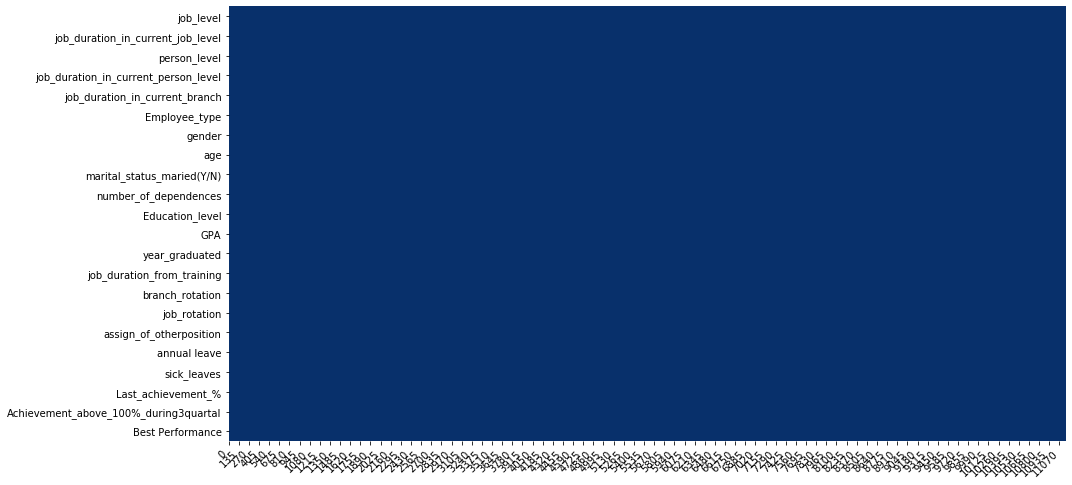

In [5]:
plot_missing_value(df)

### Handling Missing Value

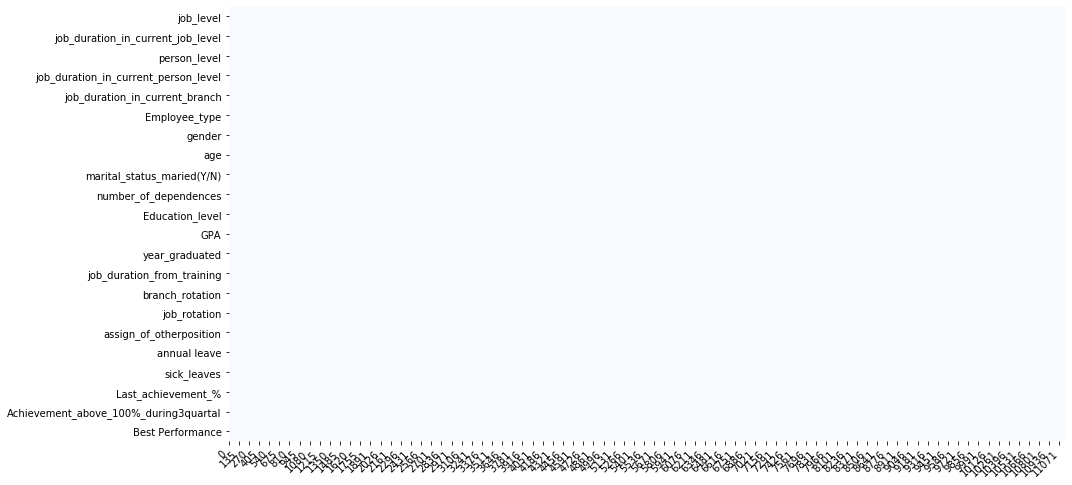

In [6]:
#hapus row NaN
df.dropna(inplace=True)

#setelah drop rows yang missing
plot_missing_value(df)

### Rename Rows

#### Gender

In [7]:
#Merubah Value Employee Type
df = df.copy()
df['gender'] = df['gender'].apply({
                        1 : 'Wanita',
                        2 : 'Pria'}.get)
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

  Employee_type  gender   age marital_status_maried(Y/N)  \
0     RM_type_A    Pria  1985                          Y   
1     RM_type_A    Pria  1989                          Y   
2     RM_type_C  Wanita  1970                          Y   
3     RM_type_A    Pria  1967                          Y   
4     RM_type_A    Pria  1965                          Y   

   number_of_dependences Education_level   GPA  year_graduated  \
0                      1         level_0  2.86            2011   
1                      0         level_1  7.28            2007   
2                      1         level_1  0.00            1989   
3                      2         level_1  0.00            1987   
4                      3         level_1  7.20            1985   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

#### Employee Type

In [8]:
#Merubah Value Employee Type
df = df.copy()
df['Employee_type'] = df['Employee_type'].apply({
                       'RM_type_A': 'Mantri Kupedes',
                       'RM_type_B': 'Mantri KUR',
                       'RM_type_C': 'Mantri Briguna'}.get)
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender   age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria  1985                          Y   
1  Mantri Kupedes    Pria  1989                          Y   
2  Mantri Briguna  Wanita  1970                          Y   
3  Mantri Kupedes    Pria  1967                          Y   
4  Mantri Kupedes    Pria  1965                          Y   

   number_of_dependences Education_level   GPA  year_graduated  \
0                      1         level_0  2.86            2011   
1                      0         level_1  7.28            2007   
2                      1         level_1  0.00            1989   
3                      2         level_1  0.00            1987   
4                      3         level_1  7.20            1985   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

#### Educational Level

In [9]:
#Merubah Value Educational Level
df = df.copy()
df['Education_level'] = df['Education_level'].apply({
                       'level_0': 'Internal course',
                       'level_1': 'SLTA',
                       'level_2': 'D1',
                       'level_3': 'D3/D4',
                       'level_4': 'S1',
                       'level_5': 'S2'}.get)
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender   age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria  1985                          Y   
1  Mantri Kupedes    Pria  1989                          Y   
2  Mantri Briguna  Wanita  1970                          Y   
3  Mantri Kupedes    Pria  1967                          Y   
4  Mantri Kupedes    Pria  1965                          Y   

   number_of_dependences  Education_level   GPA  year_graduated  \
0                      1  Internal course  2.86            2011   
1                      0             SLTA  7.28            2007   
2                      1             SLTA  0.00            1989   
3                      2             SLTA  0.00            1987   
4                      3             SLTA  7.20            1985   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

## EDA (Eksploratory Data Analysis) and Feature Engineering

### Interesting Questions:


1. Is there any correlation between job level and performance?
2. Is there any correlation employee types and their target achievement?
3. Is there any correlation between annual leave, sick leave and their target achievement?
4. Is there any extreme data or outliers among all numerical variables?

### Balance (?)

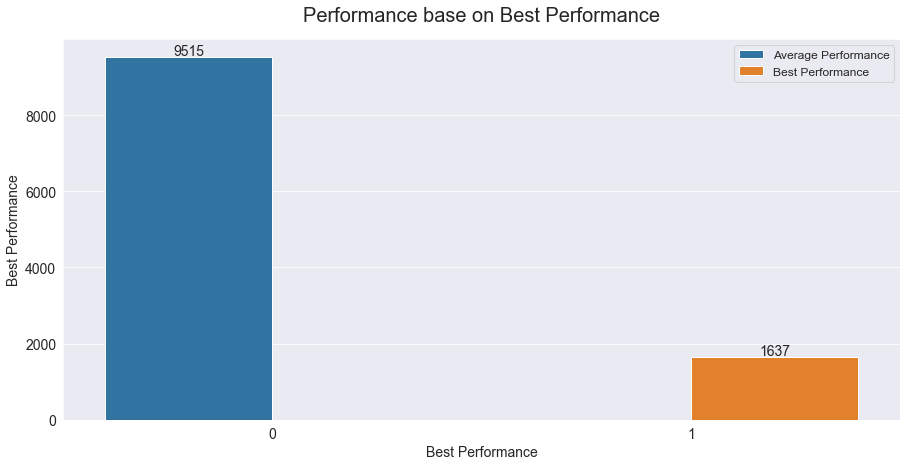

In [10]:
categoric_one(df, cols_name='Best Performance', target_name='Best Performance')

Datasets Tersebut imbalance

### Categorical 

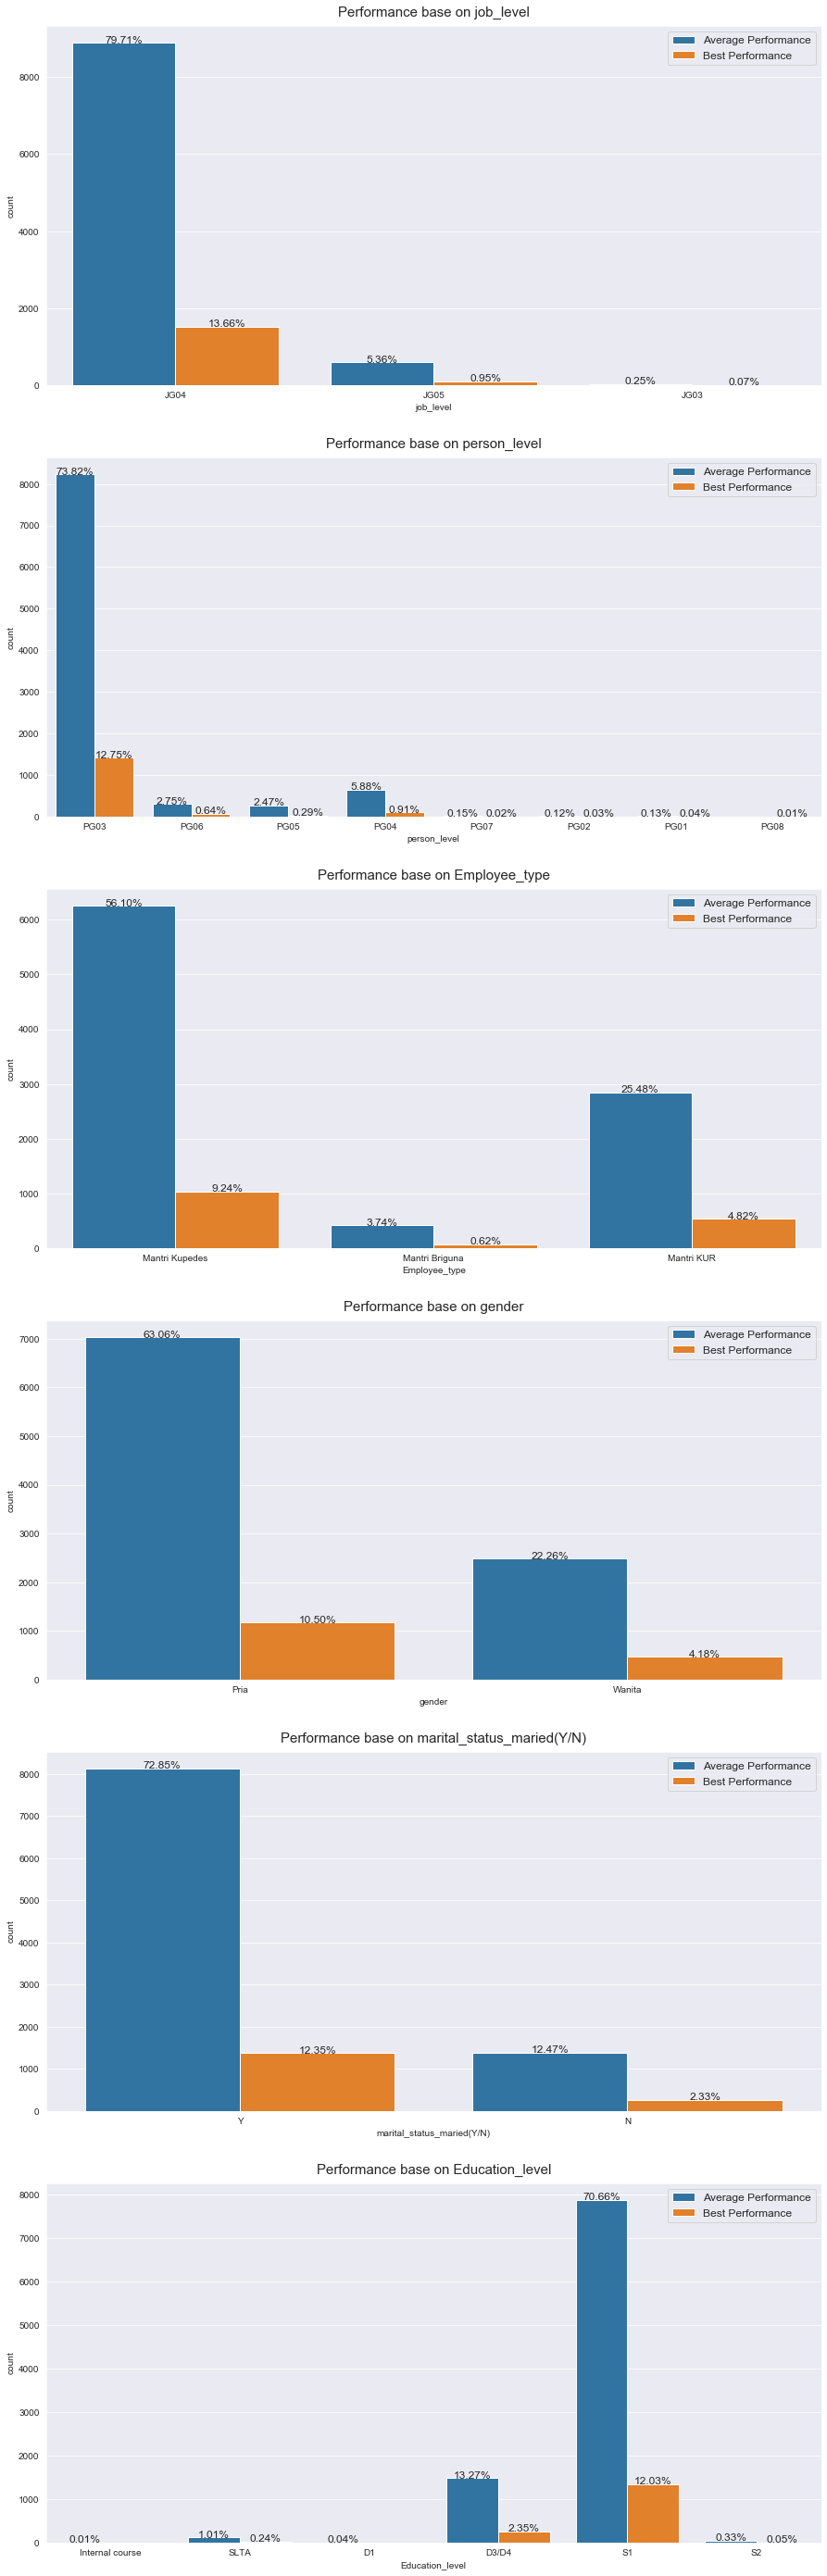

In [11]:
categoric_all(data=df, target_name='Best Performance')

### 1. Is there any correlation between job level and performance? <br> 2. Is there any correlation between annual leave, sick leave and their target achievement?

#### Correlation [Numerical]

In [12]:
num_var = [i for i in df.select_dtypes(exclude='object')]
plot_correlation_matrix(df=df, target_col='Best Performance', numeric_col=num_var)

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

### 3. Is there any correlation employee types and their target achievement?


#### Correlation Association [Categorical]

In [13]:
cat_var = [i for i in df.select_dtypes(include='object')]
plot_association_matrix(df, target_col='Best Performance', categoric_col=cat_var)

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

#### Correlation Ratio [Categical Vs Numerical]

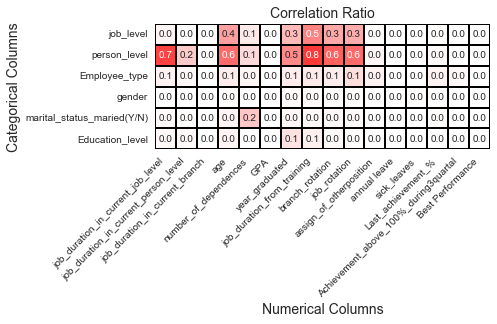

In [14]:
cat_var = [i for i in df.select_dtypes(include='object')]
num_var = [i for i in df.select_dtypes(exclude='object')]
plot_correlation_ratio(df, catvar=cat_var, numvar=num_var)

### Numerical
### 4. Is there any extreme data or outliers among all numerical variables?

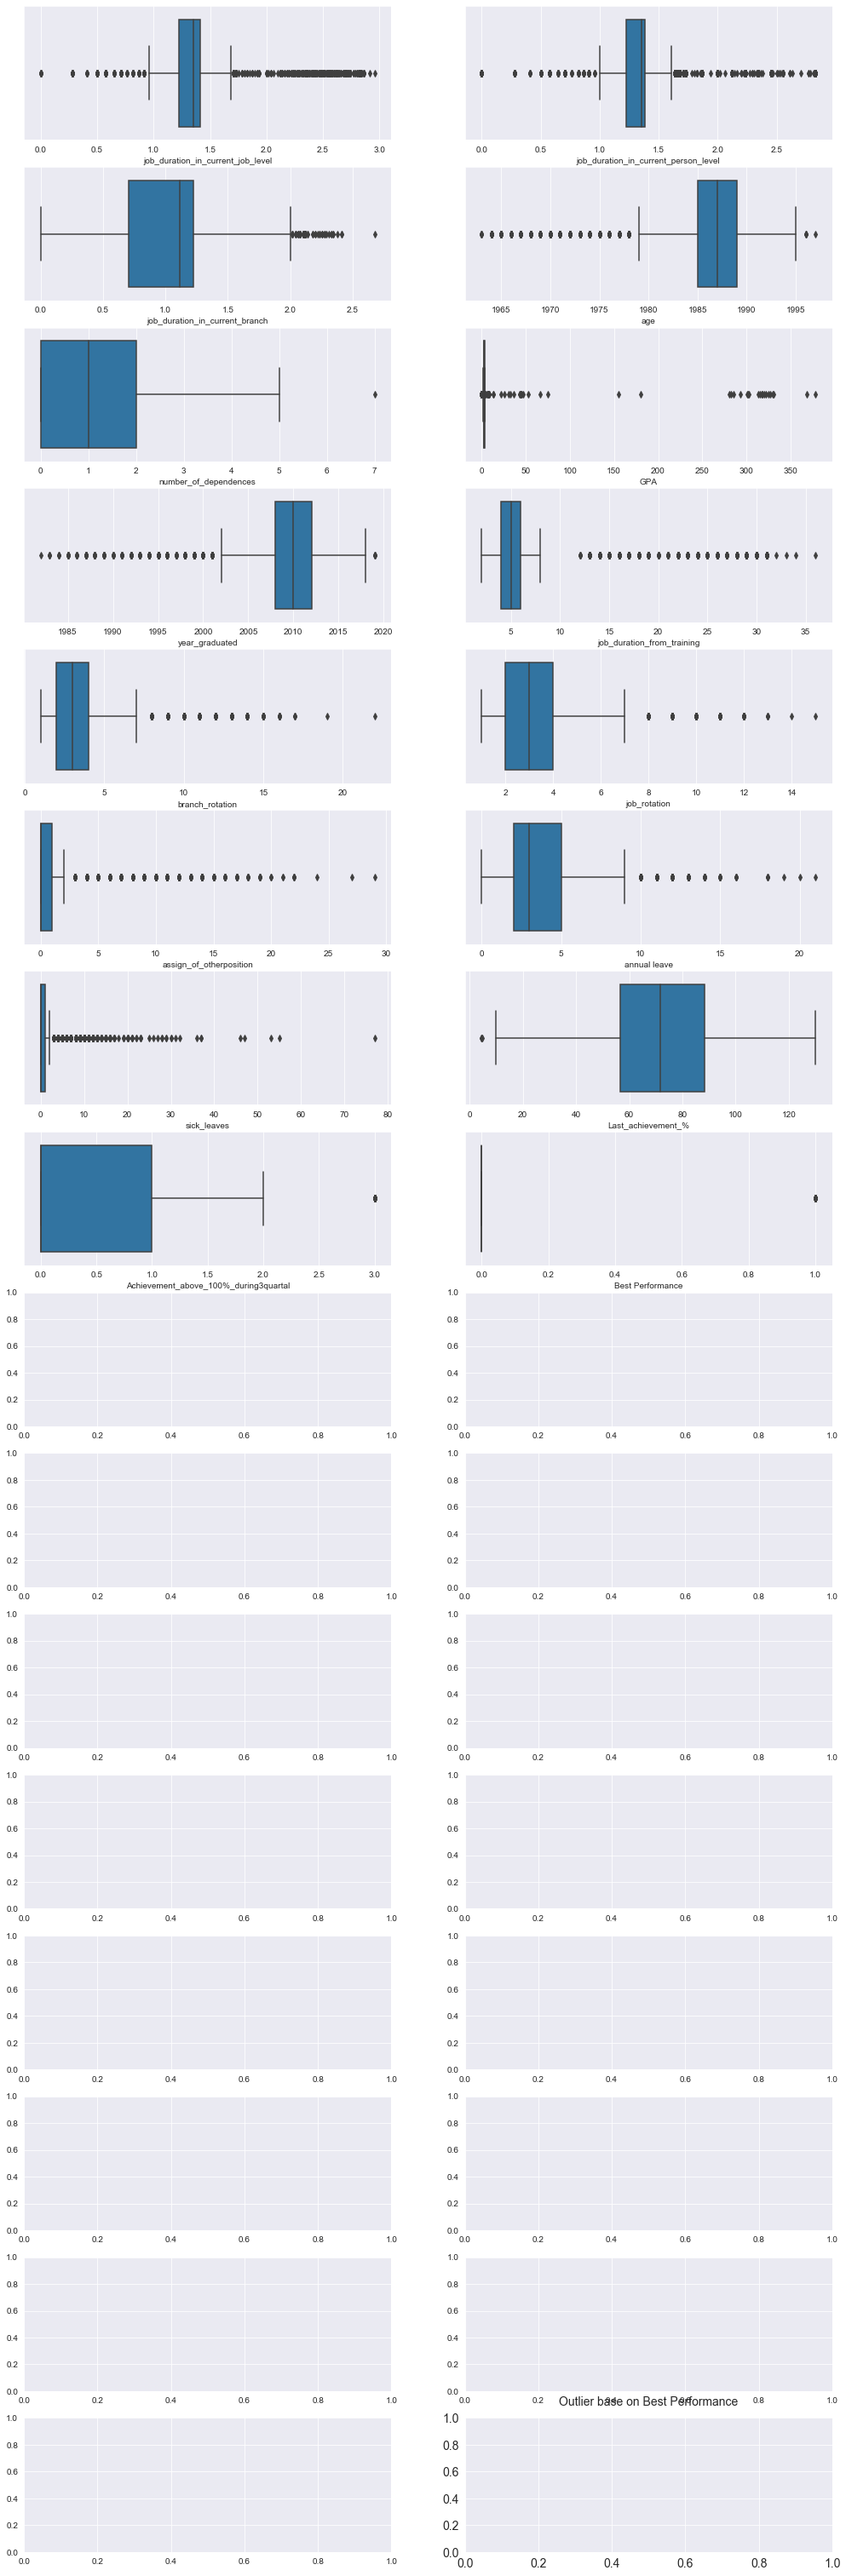

In [15]:
outlier_boxplot_all(data=df)

#### Handling Outlier

##### GPA

``IQR`` : <b> Q3-Q1 </b> <br>
``Batas Bawah : `` <b>Q1-1.5(IQR)</b><br>
``Batas Atas  : `` <b>Q3+1.5(IQR)</b><br>
``IQR`` >> Interval Quantile Range

In [16]:
pd.DataFrame(df['GPA'].describe())

GPA
count  11152.000000
mean       3.176221
std       13.322284
min        0.000000
25%        2.820000
50%        3.070000
75%        3.270000
max      378.000000

In [17]:
IQR = (df['GPA'].describe()['75%'] ) - (df['GPA'].describe()['25%'])
batas_bawah = (df['GPA'].describe()['25%']) - (1.5 * IQR)
batas_atas  = (df['GPA'].describe()['75%']) + (1.5 * IQR)

print(IQR, batas_bawah, batas_atas)

0.4500000000000002 2.1449999999999996 3.9450000000000003


In [18]:
#IPK > batas atas
df=df.copy()
df.loc[df['GPA'] > batas_atas, 'GPA'] = batas_atas

In [19]:
#IPK < batas bawah
df=df.copy()
df.loc[df['GPA'] < batas_bawah, 'GPA'] = batas_bawah

In [20]:
pd.DataFrame(df['GPA'].describe())

GPA
count  11152.000000
mean       2.968877
std        0.460360
min        2.145000
25%        2.820000
50%        3.070000
75%        3.270000
max        3.945000

#### Displot Distribution Data

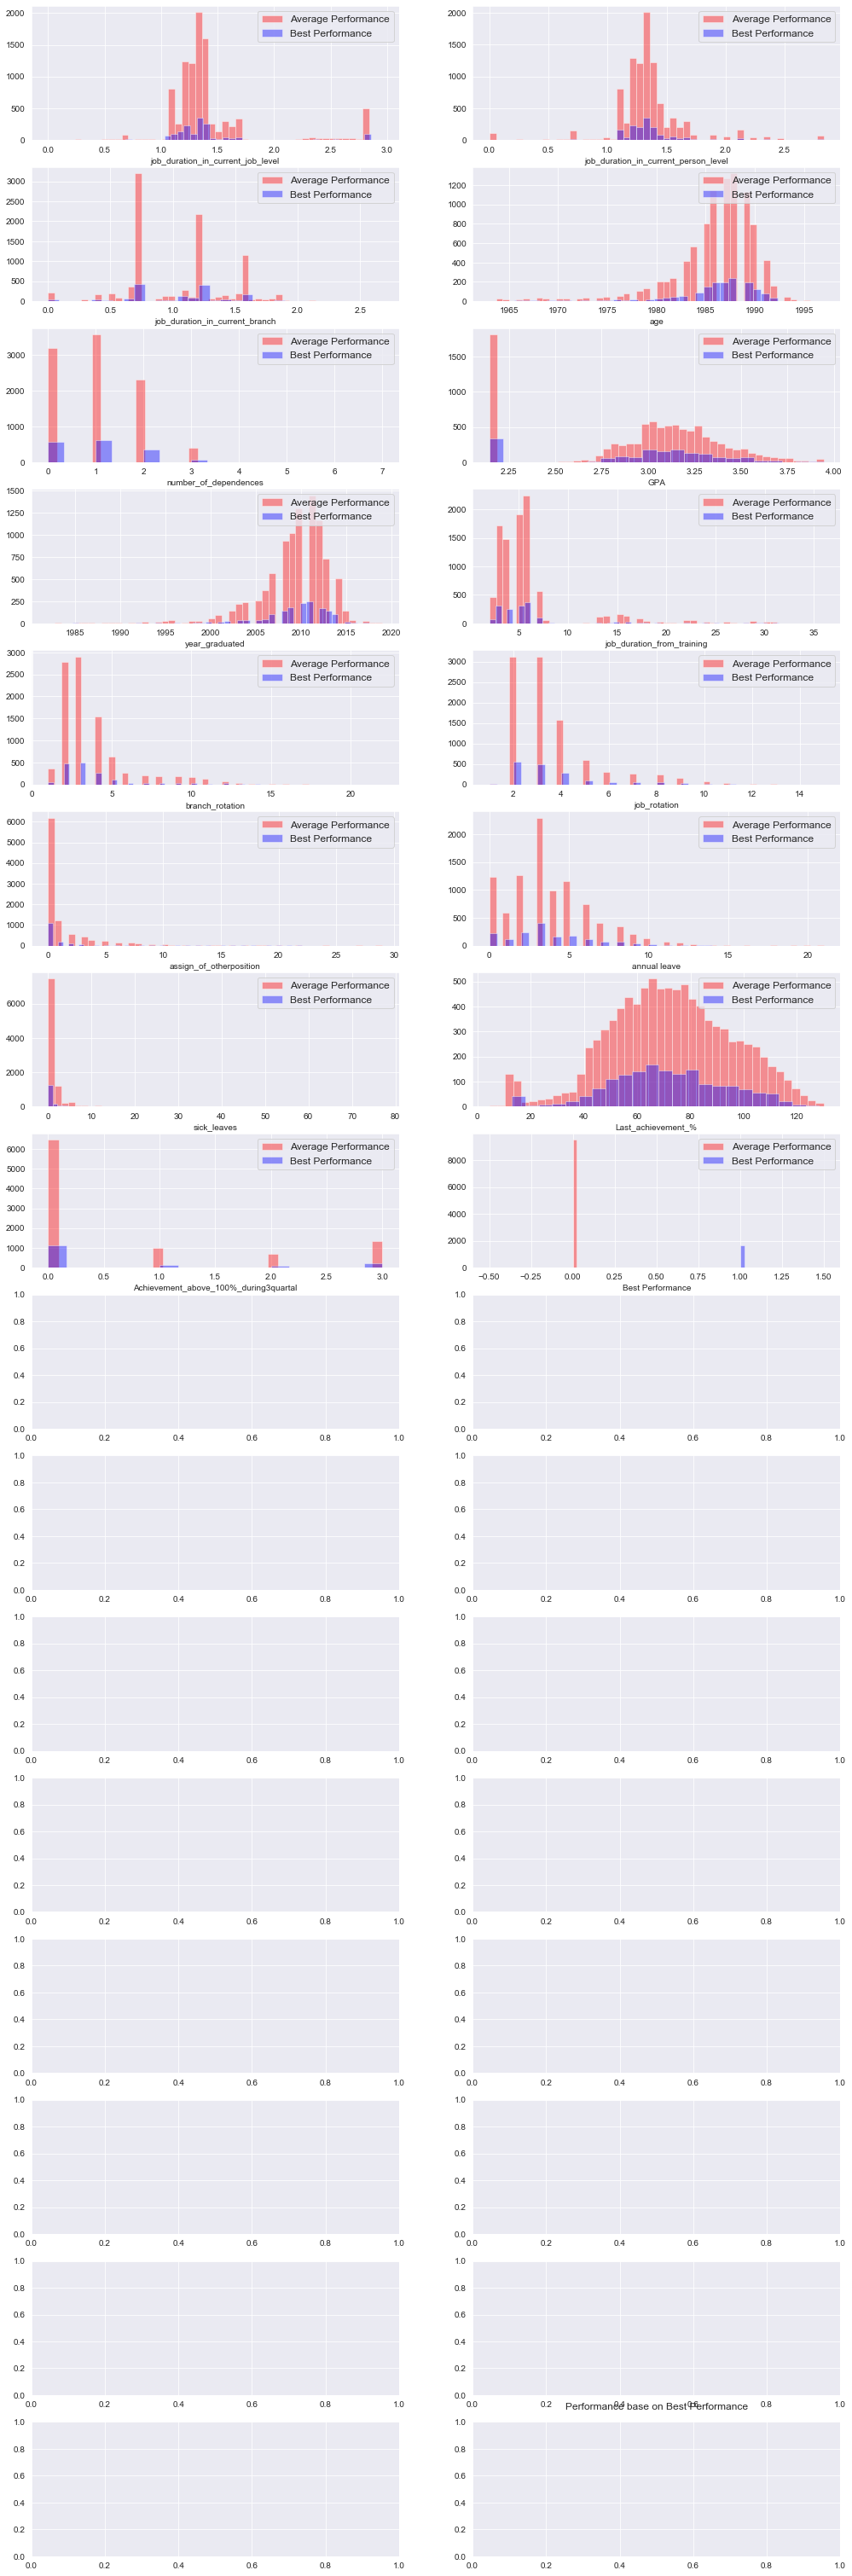

In [21]:
numeric_displot_all(df, target_name='Best Performance', label1='Average Performance', label2='Best Performance')

### Feature Engineering

##### Year Graduate

In [22]:
#Merubah year_graduated menjadi jumlah waktu lama sudah lulus
df = df.copy()
df['year_graduated'] = 2020 - df['year_graduated']
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender   age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria  1985                          Y   
1  Mantri Kupedes    Pria  1989                          Y   
2  Mantri Briguna  Wanita  1970                          Y   
3  Mantri Kupedes    Pria  1967                          Y   
4  Mantri Kupedes    Pria  1965                          Y   

   number_of_dependences  Education_level    GPA  year_graduated  \
0                      1  Internal course  2.860               9   
1                      0             SLTA  3.945              13   
2                      1             SLTA  2.145              31   
3                      2             SLTA  2.145              33   
4                      3             SLTA  3.945              35   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

##### Age

In [23]:
#Merubah tahun lahir menjadi usia
df = df.copy()
df['age'] = 2020 - df['age']
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender  age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria   35                          Y   
1  Mantri Kupedes    Pria   31                          Y   
2  Mantri Briguna  Wanita   50                          Y   
3  Mantri Kupedes    Pria   53                          Y   
4  Mantri Kupedes    Pria   55                          Y   

   number_of_dependences  Education_level    GPA  year_graduated  \
0                      1  Internal course  2.860               9   
1                      0             SLTA  3.945              13   
2                      1             SLTA  2.145              31   
3                      2             SLTA  2.145              33   
4                      3             SLTA  3.945              35   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

##### Binning GPA 

In [24]:
df['GPA'].describe()

count    11152.000000
mean         2.968877
std          0.460360
min          2.145000
25%          2.820000
50%          3.070000
75%          3.270000
max          3.945000
Name: GPA, dtype: float64

In [25]:
df = df.copy()
df['GPA'] = pd.cut(df['GPA'], [0.0, 2.82, 3.07, 3.27, 4], labels=["Kurang Memuaskan", "Memuaskan", "Sangat Memuaskan","Dengan Pujian"])
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender  age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria   35                          Y   
1  Mantri Kupedes    Pria   31                          Y   
2  Mantri Briguna  Wanita   50                          Y   
3  Mantri Kupedes    Pria   53                          Y   
4  Mantri Kupedes    Pria   55                          Y   

   number_of_dependences  Education_level               GPA  year_graduated  \
0                      1  Internal course         Memuaskan               9   
1                      0             SLTA     Dengan Pujian              13   
2                      1             SLTA  Kurang Memuaskan              31   
3                      2             SLTA  Kurang Memuaskan              33   
4                      3             SLTA     Dengan Pujian              35   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

##### Binning year Graduate

In [26]:
df['year_graduated'].describe()

count    11152.00000
mean        10.82613
std          4.11726
min          1.00000
25%          8.00000
50%         10.00000
75%         12.00000
max         38.00000
Name: year_graduated, dtype: float64

In [27]:
df = df.copy()
df['year_graduated'] = pd.cut(df['year_graduated'], [0, 4, 8, 38], labels=["Fresh Graduate", "Cukup Lama", "Sangat Lama"])
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender  age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria   35                          Y   
1  Mantri Kupedes    Pria   31                          Y   
2  Mantri Briguna  Wanita   50                          Y   
3  Mantri Kupedes    Pria   53                          Y   
4  Mantri Kupedes    Pria   55                          Y   

   number_of_dependences  Education_level               GPA year_graduated  \
0                      1  Internal course         Memuaskan    Sangat Lama   
1                      0             SLTA     Dengan Pujian    Sangat Lama   
2                      1             SLTA  Kurang Memuaskan    Sangat Lama   
3                      2             SLTA  Kurang Memuaskan    Sangat Lama   
4                      3             SLTA     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

##### Binning Number Of defedences

In [28]:
df['number_of_dependences'].describe()

count    11152.000000
mean         0.995606
std          0.881092
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: number_of_dependences, dtype: float64

In [29]:
df = df.copy()
df['number_of_dependences'] = pd.cut(df['number_of_dependences'], [0-1, 1, 3, 7], labels=["Tidak Ada", "Sedikit", "Banyak"])
df.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.352775         PG03   
1      JG04                           1.292285         PG03   
2      JG05                           2.565151         PG06   
3      JG05                           2.828427         PG06   
4      JG05                           2.828427         PG06   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.352775                        1.732051   
1                              1.292285                        1.039230   
2                              2.308679                        1.780449   
3                              1.000000                        1.385641   
4                              2.828427                        0.707107   

    Employee_type  gender  age marital_status_maried(Y/N)  \
0  Mantri Kupedes    Pria   35                          Y   
1  Mantri Kupedes    Pria   31                          Y   
2  Mantri Briguna  Wanita   50                          Y   
3  Mantri Kupedes    Pria   53                          Y   
4  Mantri Kupedes    Pria   55                          Y   

  number_of_dependences  Education_level               GPA year_graduated  \
0             Tidak Ada  Internal course         Memuaskan    Sangat Lama   
1             Tidak Ada             SLTA     Dengan Pujian    Sangat Lama   
2             Tidak Ada             SLTA  Kurang Memuaskan    Sangat Lama   
3               Sedikit             SLTA  Kurang Memuaskan    Sangat Lama   
4               Sedikit             SLTA     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           4                2             3   
1                           4                4             3   
2                          28               10             9   
3                          29               11             6   
4                          30                9             8   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        2             3            0               46.37   
1                        0             0            1               47.68   
2                        6             2            1               40.73   
3                        0             4           10               47.42   
4                        2             3            0               47.18   

   Achievement_above_100%_during3quartal  Best Performance  
0                                    0.0                 0  
1                                    0.0                 0  
2                                    0.0                 0  
3                                    0.0                 1  
4                                    0.0                 0

#### Drop Columns

In [30]:
# df = df.copy()
# df.drop(columns=['job_level','person_level'], inplace=True)
# df.head()

### PCA Analysis

In [ ]:
# from sklearn.decomposition import PCA

In [ ]:
# pca = PCA(n_components=2, whiten=True)

# X_train_pca = pca.fit_transform(X_train)
# X_test_pca  = pca.transform(X_test)

In [ ]:
# plt.figure(figsize=(15, 7))
# sns.scatterplot(X_train_pca[:, 0], X_train_pca[:, 1], hue=y_train);

In [ ]:
# plt.figure(figsize=(15, 7))
# sns.scatterplot(X_test_pca[:, 0], X_test_pca[:, 1], hue=y_test);

#### Tune PCA Components

In [ ]:
# pca = PCA().fit(X_train)
# plt.figure(figsize=(15, 7))
# plt.plot(pca.explained_variance_ratio_.cumsum())
# plt.xlabel("n_components")
# plt.ylabel("Cummulative Explained Variance")
# plt.show();

## Dataset Splitting 

### Smote Sampling

##### Handling Imblance >> [SMOTENC] >> Upsampling Minority Class

In [30]:
X = df.drop('Best Performance', axis=1)
y = df['Best Performance']

#Before
print("Before OverSampling, counts of label '1':{}".format(sum(y==1)))
print("Before OverSampling, counts of label '0':{}".format(sum(y==0)))

#smote
sm = SMOTENC(categorical_features=[0, 2, 5, 6, 8, 9, 10, 11, 12], random_state=42, sampling_strategy=0.3)
X_smote, y_smote= sm.fit_resample(X, y)

#After
print('\nAfter SmoteSampling, the shape of X_train : {}'.format(X_smote.shape))
print('After SmoteSampling, the shape of y_train : {} \n'.format(y_smote.shape))

print("After SmoteSampling, counts of label '1': {}".format(sum(y_smote==1)))
print("After SmoteSampling, counts of label '0': {}".format(sum(y_smote==0)))

#apakah ada data yang terduplikasi??
print("\nData X Terduplikasi : ", X_smote.duplicated().sum())
y_smote.value_counts(normalize=True)

Before OverSampling, counts of label '1':1637
Before OverSampling, counts of label '0':9515

After SmoteSampling, the shape of X_train : (12369, 21)
After SmoteSampling, the shape of y_train : (12369,) 

After SmoteSampling, counts of label '1': 2854
After SmoteSampling, counts of label '0': 9515

Data X Terduplikasi :  0


0    0.769262
1    0.230738
Name: Best Performance, dtype: float64

##### Handling Imblance >> [RandomUnderSampling] >> Down Sampling Majority Class

In [31]:
us = RandomUnderSampler(random_state=42, sampling_strategy=.8)
X_resampled, y_resampled = us.fit_resample(X_smote, y_smote)

#Before
print("Before Under Sampling '0' : ", sum(y_smote==0))
print("Before Under Sampling '1' : ", sum(y_smote==1))

#After
print("\nAfter Under Sampling '0'  : ", sum(y_resampled==0))
print("After Under Sampling '1'  : ", sum(y_resampled==1))

#Cekduplikasi
print("\nJumlah Data Terduplikasi  : ", X_resampled.duplicated().sum())
y_resampled.value_counts(normalize=True)

Before Under Sampling '0' :  9515
Before Under Sampling '1' :  2854

After Under Sampling '0'  :  3567
After Under Sampling '1'  :  2854

Jumlah Data Terduplikasi  :  0


0    0.555521
1    0.444479
Name: Best Performance, dtype: float64

##### Splitting Xtrain, ytrain 

In [32]:
# X = df.drop('Best Performance', axis=1)
# y = df['Best Performance']

#splitting
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42, test_size=0.20, stratify=y_resampled)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print("Total Duplikasi Data X_train    : ", X_train.duplicated().sum())
print("Total Duplikasi Data X_test     : ", X_test.duplicated().sum())

(5136, 21) (1285, 21) (5136,) (1285,)
Total Duplikasi Data X_train    :  0
Total Duplikasi Data X_test     :  0


## Training

### Preprocessor

In [33]:
cat_features = ['Employee_type','GPA','marital_status_maried(Y/N)','job_level','person_level',
                'Education_level','year_graduated','number_of_dependences','gender']

num_features = ['job_duration_in_current_job_level','job_duration_in_current_person_level',
                'job_duration_in_current_branch','age','branch_rotation','job_rotation',
                'assign_of_otherposition','Last_achievement_%','Achievement_above_100%_during3quartal',
                'job_duration_from_training','annual leave','sick_leaves']

In [34]:
# preprocessing
preprocessor = ColumnTransformer([('numeric', num_pipe(), num_features),
                                  ('categoric', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features)])

### Without Tuning

#### XGBoost

In [75]:
(y_train.value_counts()[0]/y_train.value_counts()[1]) 

1.2496714848883048

In [76]:
#imbalance weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1]) #2.8573573573573574

#pipeline
xgb = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(random_state=42,scale_pos_weight=weight))
])

#model - fine tuning
xgb.fit(X_train, y_train)

#testing
y_pred = xgb.predict_proba(X_test)[:,1]

#report
xgb_without_tune_test = roc_auc_score(y_test, y_pred)
print('ROC-AUC : ', xgb_without_tune_test)
plot_classification_report(X_train, y_train, X_test, y_test, xgb, report=True)

#save model
save_model(xgb, "model_smooteenc_xgboost/xgb_without_tune_.pkl")

ROC-AUC :  0.7152803327986186
Train report
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      2853
           1       0.72      0.63      0.67      2283

    accuracy                           0.73      5136
   macro avg       0.73      0.72      0.72      5136
weighted avg       0.73      0.73      0.72      5136


Test report
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       714
           1       0.62      0.56      0.59       571

    accuracy                           0.65      1285
   macro avg       0.65      0.64      0.65      1285
weighted avg       0.65      0.65      0.65      1285

Model is pickled as model/model_smooteenc_xgboost/xgb_without_tune_.pkl


### With Tuning

#### XGBoost 1

In [77]:
(y_train.value_counts()[0]/y_train.value_counts()[1]) 

1.2496714848883048

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


{'model__colsample_bytree': 0.4508282578113725, 'model__gamma': 8, 'model__learning_rate': 0.042697331393741954, 'model__max_depth': 10, 'model__n_estimators': 110, 'model__reg_alpha': 0.002946547125896616, 'model__reg_lambda': 0.0010766013333137511, 'model__subsample': 0.4775667166978932} 

0.8478302956720445 0.7429378422734759 0.7457210554975056
Train report
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2853
           1       0.78      0.65      0.71      2283

    accuracy                           0.76      5136
   macro avg       0.77      0.75      0.75      5136
weighted avg       0.76      0.76      0.76      5136


Test report
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       714
           1       0.68      0.58      0.63       571

    accuracy                           0.69      1285
   macro avg       0.69      0.68      0.68      1285
weighted avg       0.69  

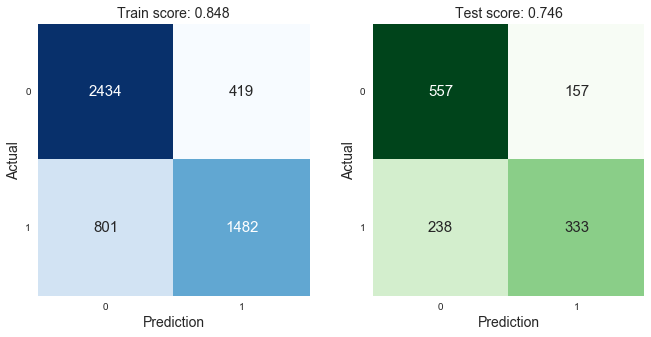

In [201]:
# preprocessing
preprocessor = ColumnTransformer([('numeric', num_pipe(), num_features),
                                  ('categoric', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features)])

#imbalance weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1]) 

#pipeline
xgb_model = Pipeline([
    ('prep', preprocessor),
    ('model', XGBClassifier(random_state=42, scale_pos_weight=weight))
])

#parameter tuning
params = {'model__max_depth': Integer(low=8, high=10),
          'model__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
          'model__n_estimators': Integer(low=100, high=150),
          'model__subsample': Real(low=0.3, high=0.5, prior='uniform'),
          'model__gamma': Integer(low=8, high=10),
          'model__colsample_bytree': Real(low=0.4, high=0.5, prior='uniform'),
          'model__reg_alpha': Real(low=-5, high=1, prior='log-uniform'),
          'model__reg_lambda': Real(low=-5, high=1, prior='log-uniform')}

#model - fine tuning
xgb_tune = RandomizedSearchCV(xgb_model, params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_tune.fit(X_train, y_train)

#report
xgb_roc_tune_train  = xgb_tune.score(X_train, y_train)
xgb_roc_tune_valid  = xgb_tune.best_score_
xgb_roc_tune_test   = xgb_tune.score(X_test, y_test)

print(xgb_tune.best_params_, "\n")
print(xgb_roc_tune_train, xgb_roc_tune_valid, xgb_roc_tune_test)
plot_classification_report(X_train, y_train, X_test, y_test, xgb_tune, report=True)
plot_confusion_matrix(X_train, y_train, X_test, y_test, xgb_tune)

#save model
save_model(xgb_tune, "model_smooteenc_xgboost/xgb_with_tune_.pkl")

#### XGBoost 2

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


{'model__colsample_bytree': 0.49453485076512665, 'model__gamma': 5, 'model__learning_rate': 0.0402168667160478, 'model__max_depth': 9, 'model__n_estimators': 137, 'model__reg_alpha': 0.6273440467918276, 'model__reg_lambda': 1.4199237216864013e-05, 'model__subsample': 0.39385311002328016} 

0.8634550102028142 0.7431258408113396 0.7411882441242695
Model is pickled as model/model_smooteenc_xgboost/xgb_with_tune_2.pkl


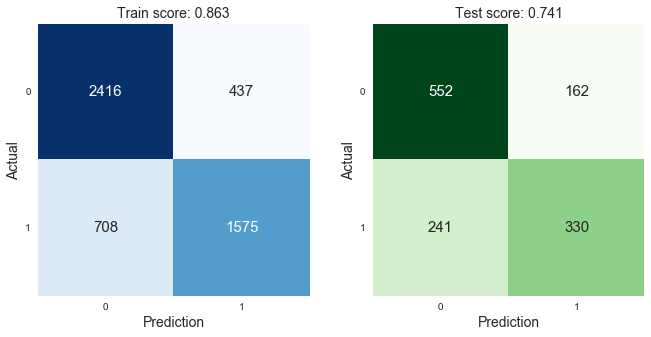

In [189]:
# preprocessing
preprocessor = ColumnTransformer([('numeric', num_pipe(transform='yeo-johnson', scaling='standard'), num_features),
                                  ('categoric', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features)])

#imbalance weight
weight = (y_train.value_counts()[0]/y_train.value_counts()[1]) 

#pipeline
xgb_model = Pipeline([
    ('prep', preprocessor),
    ('model', XGBClassifier(random_state=42, scale_pos_weight=weight))
])

#parameter tuning
{'algo__max_depth': Integer(low=7, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.7, prior='uniform'),
 'algo__gamma': Integer(low=7, high=10),
 'algo__colsample_bytree': Real(low=0.3, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

#model - fine tuning
xgb_tune = RandomizedSearchCV(xgb_model, params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_tune.fit(X_train, y_train)

#report
xgb_roc_tune_train2  = xgb_tune.score(X_train, y_train)
xgb_roc_tune_valid2  = xgb_tune.best_score_
xgb_roc_tune_test2   = xgb_tune.score(X_test, y_test)

print(xgb_tune.best_params_, "\n")
print(xgb_roc_tune_train2, xgb_roc_tune_valid2, xgb_roc_tune_test2)
# plot_classification_report(X_train, y_train, X_test, y_test, xgb_tune, report=True)
plot_confusion_matrix(X_train, y_train, X_test, y_test, xgb_tune)

#save model
save_model(xgb_tune, "model_smooteenc_xgboost/xgb_with_tune_2.pkl")

## Submission

#####  Import Data Testing

In [37]:
test = pd.read_csv('../data/test.csv')
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender   age marital_status_maried(Y/N)  \
0     RM_type_A       1  1988                          N   
1     RM_type_B       2  1991                          N   
2     RM_type_A       2  1989                          Y   
3     RM_type_A       2  1990                          Y   
4     RM_type_B       1  1985                          Y   

   number_of_dependences Education_level   GPA  year_graduated  \
0                      0         level_3  3.08            2009   
1                      0         level_4  3.31            2014   
2                      1         level_4  3.44            2011   
3                      1         level_4  0.00            2014   
4                      0         level_4  3.34            2007   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Binning GPA 

``IQR`` : <b> Q3-Q1 </b> <br>
``Batas Bawah : `` <b>Q1-1.5(IQR)</b><br>
``Batas Atas  : `` <b>Q3+1.5(IQR)</b><br>
``IQR`` >> Interval Quantile Range

In [38]:
#IPK > batas atas
test=test.copy()
test.loc[test['GPA'] > batas_atas, 'GPA'] = batas_atas

In [39]:
#IPK < batas bawah
test=test.copy()
test.loc[test['GPA'] < batas_bawah, 'GPA'] = batas_bawah

In [40]:
test['GPA'].describe()

count    6000.000000
mean        2.976281
std         0.465470
min         2.145000
25%         2.830000
50%         3.080000
75%         3.280000
max         3.945000
Name: GPA, dtype: float64

In [41]:
test = test.copy()
test['GPA'] = pd.cut(test['GPA'], [0.0, 2.82, 3.07, 3.27, 4], labels=["Kurang Memuaskan", "Memuaskan", "Sangat Memuaskan","Dengan Pujian"])
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender   age marital_status_maried(Y/N)  \
0     RM_type_A       1  1988                          N   
1     RM_type_B       2  1991                          N   
2     RM_type_A       2  1989                          Y   
3     RM_type_A       2  1990                          Y   
4     RM_type_B       1  1985                          Y   

   number_of_dependences Education_level               GPA  year_graduated  \
0                      0         level_3  Sangat Memuaskan            2009   
1                      0         level_4     Dengan Pujian            2014   
2                      1         level_4     Dengan Pujian            2011   
3                      1         level_4  Kurang Memuaskan            2014   
4                      0         level_4     Dengan Pujian            2007   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Age

In [42]:
#Merubah year_graduated menjadi jumlah waktu lama sudah lulus
test = test.copy()
test['age'] = 2020 - test['age']
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender  age marital_status_maried(Y/N)  \
0     RM_type_A       1   32                          N   
1     RM_type_B       2   29                          N   
2     RM_type_A       2   31                          Y   
3     RM_type_A       2   30                          Y   
4     RM_type_B       1   35                          Y   

   number_of_dependences Education_level               GPA  year_graduated  \
0                      0         level_3  Sangat Memuaskan            2009   
1                      0         level_4     Dengan Pujian            2014   
2                      1         level_4     Dengan Pujian            2011   
3                      1         level_4  Kurang Memuaskan            2014   
4                      0         level_4     Dengan Pujian            2007   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Binning year Graduate

In [43]:
#Merubah year_graduated menjadi jumlah waktu lama sudah lulus
test = test.copy()
test['year_graduated'] = 2020 - test['year_graduated']
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender  age marital_status_maried(Y/N)  \
0     RM_type_A       1   32                          N   
1     RM_type_B       2   29                          N   
2     RM_type_A       2   31                          Y   
3     RM_type_A       2   30                          Y   
4     RM_type_B       1   35                          Y   

   number_of_dependences Education_level               GPA  year_graduated  \
0                      0         level_3  Sangat Memuaskan              11   
1                      0         level_4     Dengan Pujian               6   
2                      1         level_4     Dengan Pujian               9   
3                      1         level_4  Kurang Memuaskan               6   
4                      0         level_4     Dengan Pujian              13   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

In [44]:
test = test.copy()
test['year_graduated'] = pd.cut(test['year_graduated'], [0-1, 4, 8, 38], labels=["Fresh Graduate", "Cukup Lama", "Sangat Lama"])
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender  age marital_status_maried(Y/N)  \
0     RM_type_A       1   32                          N   
1     RM_type_B       2   29                          N   
2     RM_type_A       2   31                          Y   
3     RM_type_A       2   30                          Y   
4     RM_type_B       1   35                          Y   

   number_of_dependences Education_level               GPA year_graduated  \
0                      0         level_3  Sangat Memuaskan    Sangat Lama   
1                      0         level_4     Dengan Pujian     Cukup Lama   
2                      1         level_4     Dengan Pujian    Sangat Lama   
3                      1         level_4  Kurang Memuaskan     Cukup Lama   
4                      0         level_4     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Binning Number Of defedences

In [45]:
test = test.copy()
test['number_of_dependences'] = pd.cut(test['number_of_dependences'], [0-1, 1, 3, 7], labels=["Tidak Ada", "Sedikit", "Banyak"])
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender  age marital_status_maried(Y/N) number_of_dependences  \
0     RM_type_A       1   32                          N             Tidak Ada   
1     RM_type_B       2   29                          N             Tidak Ada   
2     RM_type_A       2   31                          Y             Tidak Ada   
3     RM_type_A       2   30                          Y             Tidak Ada   
4     RM_type_B       1   35                          Y             Tidak Ada   

  Education_level               GPA year_graduated  \
0         level_3  Sangat Memuaskan    Sangat Lama   
1         level_4     Dengan Pujian     Cukup Lama   
2         level_4     Dengan Pujian    Sangat Lama   
3         level_4  Kurang Memuaskan     Cukup Lama   
4         level_4     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Gender

In [46]:
#Merubah Value Gender
test = test.copy()
test['gender'] = test['gender'].apply({
                        1 : 'Wanita',
                        2 : 'Pria'}.get)
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

  Employee_type  gender  age marital_status_maried(Y/N) number_of_dependences  \
0     RM_type_A  Wanita   32                          N             Tidak Ada   
1     RM_type_B    Pria   29                          N             Tidak Ada   
2     RM_type_A    Pria   31                          Y             Tidak Ada   
3     RM_type_A    Pria   30                          Y             Tidak Ada   
4     RM_type_B  Wanita   35                          Y             Tidak Ada   

  Education_level               GPA year_graduated  \
0         level_3  Sangat Memuaskan    Sangat Lama   
1         level_4     Dengan Pujian     Cukup Lama   
2         level_4     Dengan Pujian    Sangat Lama   
3         level_4  Kurang Memuaskan     Cukup Lama   
4         level_4     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Employee Type

In [47]:
#Merubah Value Employee Type
test = test.copy()
test['Employee_type'] = test['Employee_type'].apply({
                       'RM_type_A': 'Mantri Kupedes',
                       'RM_type_B': 'Mantri KUR',
                       'RM_type_C': 'Mantri Briguna'}.get)
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

    Employee_type  gender  age marital_status_maried(Y/N)  \
0  Mantri Kupedes  Wanita   32                          N   
1      Mantri KUR    Pria   29                          N   
2  Mantri Kupedes    Pria   31                          Y   
3  Mantri Kupedes    Pria   30                          Y   
4      Mantri KUR  Wanita   35                          Y   

  number_of_dependences Education_level               GPA year_graduated  \
0             Tidak Ada         level_3  Sangat Memuaskan    Sangat Lama   
1             Tidak Ada         level_4     Dengan Pujian     Cukup Lama   
2             Tidak Ada         level_4     Dengan Pujian    Sangat Lama   
3             Tidak Ada         level_4  Kurang Memuaskan     Cukup Lama   
4             Tidak Ada         level_4     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Educational Level

In [48]:
#Merubah Value Educational Level
test = test.copy()
test['Education_level'] = test['Education_level'].apply({
                       'level_0': 'Internal course',
                       'level_1': 'SLTA',
                       'level_2': 'D1',
                       'level_3': 'D3/D4',
                       'level_4': 'S1',
                       'level_5': 'S2'}.get)
test.head()

job_level  job_duration_in_current_job_level person_level  \
0      JG04                           1.256981         PG03   
1      JG04                           1.224745         PG03   
2      JG04                           0.500000         PG03   
3      JG04                           1.256981         PG03   
4      JG04                           1.352775         PG03   

   job_duration_in_current_person_level  job_duration_in_current_branch  \
0                              1.256981                        0.707107   
1                              1.224745                        1.256981   
2                              0.500000                        1.081665   
3                              1.256981                        1.802776   
4                              1.352775                        1.224745   

    Employee_type  gender  age marital_status_maried(Y/N)  \
0  Mantri Kupedes  Wanita   32                          N   
1      Mantri KUR    Pria   29                          N   
2  Mantri Kupedes    Pria   31                          Y   
3  Mantri Kupedes    Pria   30                          Y   
4      Mantri KUR  Wanita   35                          Y   

  number_of_dependences Education_level               GPA year_graduated  \
0             Tidak Ada           D3/D4  Sangat Memuaskan    Sangat Lama   
1             Tidak Ada              S1     Dengan Pujian     Cukup Lama   
2             Tidak Ada              S1     Dengan Pujian    Sangat Lama   
3             Tidak Ada              S1  Kurang Memuaskan     Cukup Lama   
4             Tidak Ada              S1     Dengan Pujian    Sangat Lama   

   job_duration_from_training  branch_rotation  job_rotation  \
0                           6                4             2   
1                           2                2             2   
2                           4                2             2   
3                           3                1             3   
4                           5                3             2   

   assign_of_otherposition  annual leave  sick_leaves  Last_achievement_%  \
0                        6             3            7               84.02   
1                        0             1            0               63.74   
2                        0             2            1               88.19   
3                        0             3            0               25.94   
4                        0             3            0               82.32   

   Achievement_above_100%_during3quartal  
0                                    0.0  
1                                    0.0  
2                                    1.0  
3                                    0.0  
4                                    0.0

##### Drop Columns

In [49]:
# test = test.copy()
# test.drop(columns=['job_level','person_level'], inplace=True)
# test.head()

## Submit

### Load Model

In [184]:
def submit(model, filename="../hasil/smoteenc/IK___XGBv25.csv"):
    df_submit = test
    df_submit["Best Performance"] = xgb_tune.predict_proba(df_submit)[:,1]
#     df_submit["Best Performance"] = xgb_tune.predict(df_submit)
    df_submit[["Best Performance"]].to_csv(filename, index_label='index')

#predict    
submit(xgb_tune, filename="../hasil/smoteenc_xgboost/IK___XGBv25.csv")

In [188]:
predict = pd.read_csv("../hasil/smoteenc_xgboost/IK___XGBv25.csv")
predict.head()

index  Best Performance
0      0          0.297394
1      1          0.715034
2      2          0.689439
3      3          0.273449
4      4          0.556839

In [183]:
a = predict['Best Performance']
a.value_counts()

0    4540
1    1460
Name: Best Performance, dtype: int64

In [171]:
# XGBv1 >> 1822 (goodfit)
# XGBv2 >> 2298 (overfit)
# XGBv3 >> 1662 (overfit)
# XGBv4 >> 2257
# xgbv5 >>> 1857
# xgbv8 >>> 1218
# xgbv9 >> 1690 (improve)
# xgbv10 >> 1622
# xgbv11 >> 1132
# xgbv12 >> 1024
# xgbv13 >> 1789
# xgbv14 >> 1593
# xgbv15 >> 1314
# xgbv16 >> 168
# xgbv17 >> 1480
# xgbv18 >> 1610
# xgbv19 >> 1234
# xgbv20 >> 2355 (lumayan>>0,563xxx)
# xgbv21 >> 2435
# xgbv22 >> 1424
# xgbv23 >>
# xgbv24 >> 1324

## Interpretation Model

### Interpretation Model Using LIME

##### Load Best Model

In [ ]:
# model_xgb = load_model("./model/xgb_with_tune_.pkl")

##### Get Best Params

In [ ]:
best_params_ = xgb_tune.best_params_
print(best_params_)
print(xgb_tune.best_score_)

In [ ]:
#insert best_params_ to xgboost model
xgb_model.set_params(**best_params_)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
save_model(xgb_model, "xgb_.pkl")

##### Invers Feature to OneHot

In [ ]:
preprocessor = xgb_model.named_steps['prep']

In [ ]:
onehot_cat = preprocessor.named_transformers_['categoric'].categories_

In [ ]:
# onehot_cat

In [ ]:
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, onehot_cat) for val in vals]

In [ ]:
# new_ohe_features

##### Combine feature 

In [ ]:
FeaturesAll = num_features+new_ohe_features

##### Convert to DataFrame and transform --> X_train

In [ ]:
all_features_T = pd.DataFrame(xgb_model.named_steps['prep'].transform(X_train), columns=FeaturesAll)
all_features_T.head()

##### Convert DataFrame to Lime Format

In [447]:
convert_to_lime_format(X_train, categorical_names).head()

job_duration_in_current_job_level  job_duration_in_current_person_level  \
2670                           1.118034                              1.118034   
1772                           1.352775                              1.352775   
4430                           1.322876                              1.322876   
5433                           1.292285                              1.292285   
7374                           1.665121                              1.665121   

      job_duration_in_current_branch  Employee_type  gender  age  \
2670                        1.849324              2       1   33   
1772                        0.000000              1       0   33   
4430                        1.581139              0       0   33   
5433                        1.224745              1       0   31   
7374                        0.437035              2       0   37   

      marital_status_maried(Y/N) number_of_dependences  Education_level GPA  \
2670                           1                     2                2   3   
1772                           1                     2                2   1   
4430                           1                     2                2   2   
5433                           1                     2                0   1   
7374                           1                     2                2   2   

     year_graduated  job_duration_from_training  branch_rotation  \
2670              2                           6                2   
1772              0                           3                2   
4430              2                           3                2   
5433              0                           3                2   
7374              2                           6                5   

      job_rotation  assign_of_otherposition  annual leave  sick_leaves  \
2670             3                        0             9            1   
1772             2                        0             5            0   
4430             3                        0            10            0   
5433             2                        0             0            0   
7374             4                        0             3            0   

      Last_achievement_%  Achievement_above_100%_during3quartal  
2670           93.070000                                    1.0  
1772           70.730000                                    0.0  
4430           65.940000                                    0.0  
5433           69.630000                                    0.0  
7374           58.884195                                    0.0

##### Index in Categorical Columns

In [448]:
categorical_names = {}
for col in cat_features:
    categorical_names[X_train.columns.get_loc(col)] = [new_col.split("__")[1] 
                                                       for new_col in new_ohe_features 
                                                       if new_col.split("__")[0] == col]

In [449]:
# new_ohe_features

In [455]:
explainer = lime_tabular.LimeTabularExplainer(convert_to_lime_format(X_train, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train.columns,
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                              
                                 discretize_continuous=True)

In [456]:
i = 2
X_observation = X_test.iloc[[i]]
X_observation

job_duration_in_current_job_level  job_duration_in_current_person_level  \
7308                            1.68226                               1.68226   

      job_duration_in_current_branch   Employee_type gender  age  \
7308                        1.224745  Mantri Kupedes   Pria   36   

     marital_status_maried(Y/N) number_of_dependences Education_level  \
7308                          Y               Sedikit              S1   

                   GPA year_graduated  job_duration_from_training  \
7308  Sangat Memuaskan    Sangat Lama                           7   

      branch_rotation  job_rotation  assign_of_otherposition  annual leave  \
7308                4             2                       21             0   

      sick_leaves  Last_achievement_%  Achievement_above_100%_during3quartal  
7308            0                74.0                                    0.0

In [488]:
# observation = convert_to_lime_format(X_test, categorical_names, col_names=X_train.columns).values[i]
# observation = pd.DataFrame(observation)

In [489]:
# explanation = explainer.explain_instance(observation, xgb_model.predict_proba, num_features=10)
# explanation.show_in_notebook(show_table=True, show_all=False)

TypeError: '(slice(None, None, None), 0)' is an invalid key

### Interpretation Model Using Shap

##### Get Best Params

In [214]:
print(xgb_tune.best_params_)
print(xgb_tune.best_score_)

{'model__colsample_bytree': 0.4508282578113725, 'model__gamma': 8, 'model__learning_rate': 0.042697331393741954, 'model__max_depth': 10, 'model__n_estimators': 110, 'model__reg_alpha': 0.002946547125896616, 'model__reg_lambda': 0.0010766013333137511, 'model__subsample': 0.4775667166978932}
0.7429378422734759


In [215]:
#insert best_params_ to xgboost model
xgb_model.set_params(**xgb_tune.best_params_)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['job_duration_in_current_job_level',
                                                   'job_duration_in_current_person_level',
                                                   'job_duration_in_current_branch',
                                                   'age', 'branch_rotation',
                                                   'job_rotation',
                                                   'assign_of_otherposition',
                                                   'Last_achievement_%',
                                                   'Achievement_above_100%_d...
                                                   'Education_level',
                       

In [216]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['job_duration_in_current_job_level',
                                                   'job_duration_in_current_person_level',
                                                   'job_duration_in_current_branch',
                                                   'age', 'branch_rotation',
                                                   'job_rotation',
                                                   'assign_of_otherposition',
                                                   'Last_achievement_%',
                                                   'Achievement_above_100%_d...
                                                   'Education_level',
                       

In [217]:
save_model(xgb_model, "model_smooteenc_xgboost/xgb.pkl")

Model is pickled as model/model_smooteenc_xgboost/xgb.pkl


##### Invers Feature to OneHot

In [218]:
preprocessor = xgb_model.named_steps['prep']

In [219]:
onehot_cat = preprocessor.named_transformers_['categoric'].categories_

In [220]:
# onehot_cat

In [221]:
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, onehot_cat) for val in vals]

In [222]:
# new_ohe_features

##### Combine feature 

In [223]:
FeaturesAll = num_features+new_ohe_features

##### Convert to DataFrame and transform --> X_train

In [224]:
all_features_T = pd.DataFrame(xgb_model.named_steps['prep'].transform(X_train), columns=FeaturesAll)
all_features_T.head()

job_duration_in_current_job_level  job_duration_in_current_person_level  \
0                           1.322876                              1.322876   
1                           1.658312                              1.658312   
2                           1.658312                              1.658312   
3                           1.322876                              1.322876   
4                           1.292285                              1.292285   

   job_duration_in_current_branch   age  branch_rotation  job_rotation  \
0                        0.707107  29.0              3.0           3.0   
1                        0.500000  36.0              5.0           6.0   
2                        1.581139  32.0              3.0           3.0   
3                        0.648074  32.0              7.0           4.0   
4                        0.707107  35.0              3.0           3.0   

   assign_of_otherposition  Last_achievement_%  \
0                      0.0               89.01   
1                      7.0               51.88   
2                      0.0               82.70   
3                      0.0               59.48   
4                      0.0               58.14   

   Achievement_above_100%_during3quartal  job_duration_from_training  \
0                                    1.0                         4.0   
1                                    0.0                         7.0   
2                                    0.0                         5.0   
3                                    0.0                         7.0   
4                                    0.0                         6.0   

   annual leave  sick_leaves  Employee_type__Mantri Briguna  \
0           2.0          1.0                            0.0   
1           0.0          0.0                            0.0   
2           5.0          1.0                            1.0   
3           7.0          0.0                            1.0   
4           2.0          0.0                            0.0   

   Employee_type__Mantri KUR  Employee_type__Mantri Kupedes  \
0                        0.0                            1.0   
1                        0.0                            1.0   
2                        0.0                            0.0   
3                        0.0                            0.0   
4                        0.0                            1.0   

   GPA__Dengan Pujian  GPA__Kurang Memuaskan  GPA__Memuaskan  \
0                 1.0                    0.0             0.0   
1                 0.0                    1.0             0.0   
2                 1.0                    0.0             0.0   
3                 0.0                    0.0             0.0   
4                 0.0                    1.0             0.0   

   GPA__Sangat Memuaskan  marital_status_maried(Y/N)__N  \
0                    0.0                            1.0   
1                    0.0                            0.0   
2                    0.0                            0.0   
3                    1.0                            0.0   
4                    0.0                            1.0   

   marital_status_maried(Y/N)__Y  job_level__JG03  job_level__JG04  \
0                            0.0              0.0              1.0   
1                            1.0              0.0              1.0   
2                            1.0              0.0              1.0   
3                            1.0              0.0              1.0   
4                            0.0              0.0              1.0   

   job_level__JG05  person_level__PG01  person_level__PG02  \
0              0.0                 0.0                 0.0   
1              0.0                 0.0                 0.0   
2              0.0                 0.0                 0.0   
3              0.0                 0.0                 0.0   
4              0.0                 0.0                 0.0   

   person_level__PG03  person_level__PG04  person_level__PG05  

##### Get Index in Categorical Columns

In [225]:
categorical_names = {}
for col in cat_features:
    categorical_names[X_train.columns.get_loc(col)] = [new_col.split("__")[1] 
                                                       for new_col in new_ohe_features 
                                                       if new_col.split("__")[0] == col]

In [226]:
# new_ohe_features

##### Create an explainer using Shap

In [286]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])
observations = xgb_model.named_steps["prep"].transform(X_train.sample(1000, random_state=42))
shap_values = explainer.shap_values(observations)

In [335]:
observations = xgb_model.named_steps["prep"].transform(X_train.sample(1000, random_state=42))
shap_values = explainer.shap_values(observations)

In [336]:
# pd.DataFrame(observations)

##### Single Prediction


Data test ke- 563
Label/Probability Prediksi 0: 0.5329834222793579
Label/Probability Prediksi 1: 0.4670165777206421


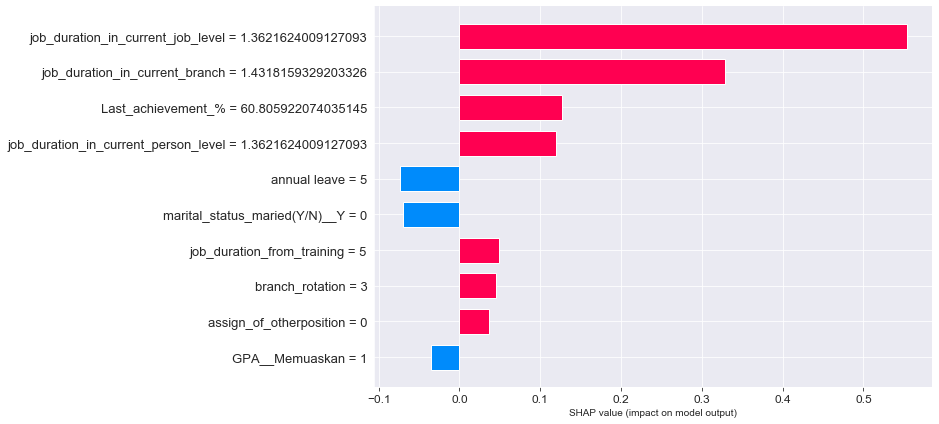

In [422]:
#test set random
# i = 189
i = np.random.randint(0, 999)
observation = test.iloc[[i], :]

# print(X_test.iloc[i])
print("\nData test ke-",i)
print("Label/Probability Prediksi 0:",xgb_model.predict_proba(observation)[:,0].item())
print("Label/Probability Prediksi 1:",xgb_model.predict_proba(observation)[:,1].item())
# print("Label asli     : ",y_test.iloc[i])

#plot
plt.figure(figsize=(10,7), facecolor='w')
plt.xticks(fontsize=12);plt.yticks(fontsize=12)


shap.bar_plot(shap_values=shap_values[i], features=observations[i], feature_names=FeaturesAll, max_display=10, show=False)
shap.force_plot(explainer.expected_value, shap_values[i], features=observations[i], feature_names=FeaturesAll, link='logit')

##### Multiple Prediction

In [234]:
shap.force_plot(explainer.expected_value, shap_values,features=observations, feature_names=FeaturesAll, link='logit')

##### Feature Importance [All Variable]

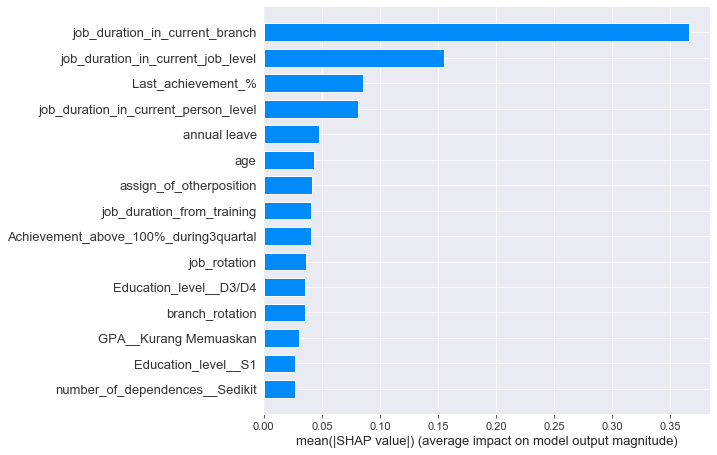

In [303]:
plt.figure(figsize=(15,7), facecolor='w')
shap.summary_plot(shap_values, observations, plot_type="bar",feature_names=FeaturesAll,max_display=15, show=False)